In [1]:
!pip install --q pandas
!pip install --q scanpy
!pip install --q palantir
!pip install --q mellon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.4/124.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 14.5 MB/s eta 0

In [43]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from sklearn.cluster import k_means
import palantir
import mellon
import scanpy as sc

import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)

In [3]:
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = [4, 4]
matplotlib.rcParams["figure.dpi"] = 125
matplotlib.rcParams["image.cmap"] = "Spectral_r"
# no bounding boxes or axis:
matplotlib.rcParams["axes.spines.bottom"] = "on"
matplotlib.rcParams["axes.spines.top"] = "off"
matplotlib.rcParams["axes.spines.left"] = "on"
matplotlib.rcParams["axes.spines.right"] = "off"



---
# Step 1: Reading and Displaying the Dataset



In [4]:
ad_url = "https://fh-pi-setty-m-eco-public.s3.amazonaws.com/mellon-tutorial/preprocessed_t-cell-depleted-bm-rna.h5ad"
ad = sc.read("data/preprocessed_t-cell-depleted-bm-rna.h5ad", backup_url=ad_url)
ad

  0%|          | 0.00/2.33G [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    varm: 'PCs', 'geneXTF'
    layers: 'Bcells_lineage_specific', 'Bcells_primed', 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivities', 'distances', 'knn

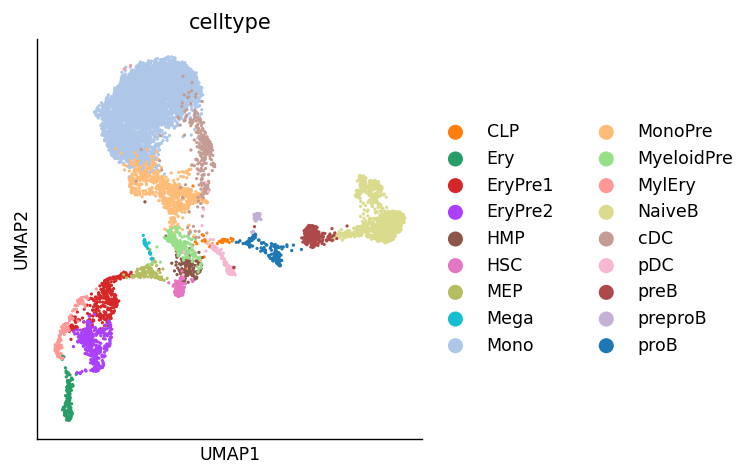

In [7]:
sc.pl.scatter(ad, basis="umap", color="celltype")



---

# Step 2: Preprocessing


In [8]:
%%time
dm_res = palantir.utils.run_diffusion_maps(ad, pca_key="X_pca", n_components=20)

CPU times: user 1min 12s, sys: 1.09 s, total: 1min 13s
Wall time: 1min 20s




---

# Step 3: Density Calculation


In [9]:
%%time
model = mellon.DensityEstimator()
log_density = model.fit_predict(ad.obsm["DM_EigenVectors"])

predictor = model.predict

ad.obs["mellon_log_density"] = log_density
ad.obs["mellon_log_density_clipped"] = np.clip(
    log_density, *np.quantile(log_density, [0.05, 1])
)

[2024-06-29 03:22:40,396] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (8,627) and rank = 1.0.
[2024-06-29 03:22:40,399] [INFO    ] Computing nearest neighbor distances.
[2024-06-29 03:22:43,690] [INFO    ] Using embedding dimensionality d=20. Use d_method="fractal" to enable effective density normalization.
[2024-06-29 03:22:44,362] [INFO    ] Using covariance function Matern52(ls=0.008487235728612248).
[2024-06-29 03:22:44,383] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2024-06-29 03:23:32,427] [INFO    ] Using rank 5,000 covariance representation.
[2024-06-29 03:23:43,518] [INFO    ] Running inference using L-BFGS-B.
[2024-06-29 03:24:00,634] [INFO    ] Computing predictive function.
CPU times: user 1min 17s, sys: 19.6 s, total: 1min 37s
Wall time: 1min 23s


In [11]:
ad

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    varm: 'PCs', 'geneXTF'
    layers: 'Bcells_lineage_specific', 'Bcells_primed', 'MAGIC_imputed_data'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivities', 'distances', 'knn

In [13]:
ad.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,DoubletScores,n_counts,leiden,phenograph,log_n_counts,celltype,palantir_pseudotime,selection,NaiveB_lineage,mellon_log_density,mellon_log_density_clipped
IM-1393_BoneMarrow_TcellDep_1_multiome#GTGAGCGAGTCTCACC-1,IM-1393_BoneMarrow_TcellDep_1_multiome,2501,5612.0,735.0,13.096934,0,0.061947,5593.0,7,3,3.749118,MonoPre,0.138621,False,False,105.430628,105.430628
IM-1393_BoneMarrow_TcellDep_1_multiome#GAGTCAAAGTCCTTCA-1,IM-1393_BoneMarrow_TcellDep_1_multiome,5015,21563.0,1883.0,8.732552,0,0.050938,21505.0,8,9,4.333709,EryPre1,0.336803,False,False,124.102672,124.102672
IM-1393_BoneMarrow_TcellDep_1_multiome#TGTGCGCAGTCGCTAG-1,IM-1393_BoneMarrow_TcellDep_1_multiome,1102,2297.0,50.0,2.176752,0,0.049296,2276.0,13,12,3.361161,Ery,0.684445,False,False,114.564752,114.564752
IM-1393_BoneMarrow_TcellDep_1_multiome#ATATGTCCAATGCCTA-1,IM-1393_BoneMarrow_TcellDep_1_multiome,2575,5653.0,663.0,11.728286,0,0.106040,5616.0,3,0,3.752279,Mono,0.311772,False,False,166.144788,166.144788
IM-1393_BoneMarrow_TcellDep_1_multiome#CTTAGTTTCGCTAGTG-1,IM-1393_BoneMarrow_TcellDep_1_multiome,1262,2651.0,68.0,2.565070,0,0.059961,2618.0,13,12,3.423410,Ery,0.704443,False,False,111.669838,111.669838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IM-1393_BoneMarrow_TcellDep_2_multiome#ATCCGTGAGGGATTAG-1,IM-1393_BoneMarrow_TcellDep_2_multiome,1968,3902.0,393.0,10.071758,1,0.037037,3895.0,0,0,3.591287,Mono,0.309793,False,False,132.005358,132.005358
IM-1393_BoneMarrow_TcellDep_2_multiome#ATTTAGGTCAGGTTTA-1,IM-1393_BoneMarrow_TcellDep_2_multiome,2264,4902.0,413.0,8.425133,1,0.050847,4895.0,2,1,3.690373,Mono,0.306938,False,False,156.200422,156.200422
IM-1393_BoneMarrow_TcellDep_2_multiome#GATGGACAGATAAAGC-1,IM-1393_BoneMarrow_TcellDep_2_multiome,2371,4947.0,286.0,5.781282,1,0.129032,4931.0,1,0,3.694342,Mono,0.311873,False,False,165.633883,165.633883
IM-1393_BoneMarrow_TcellDep_2_multiome#GAAGGCTAGCTATATG-1,IM-1393_BoneMarrow_TcellDep_2_multiome,1764,3554.0,440.0,12.380417,1,0.033175,3545.0,0,0,3.550717,Mono,0.312016,False,False,168.299789,168.299789


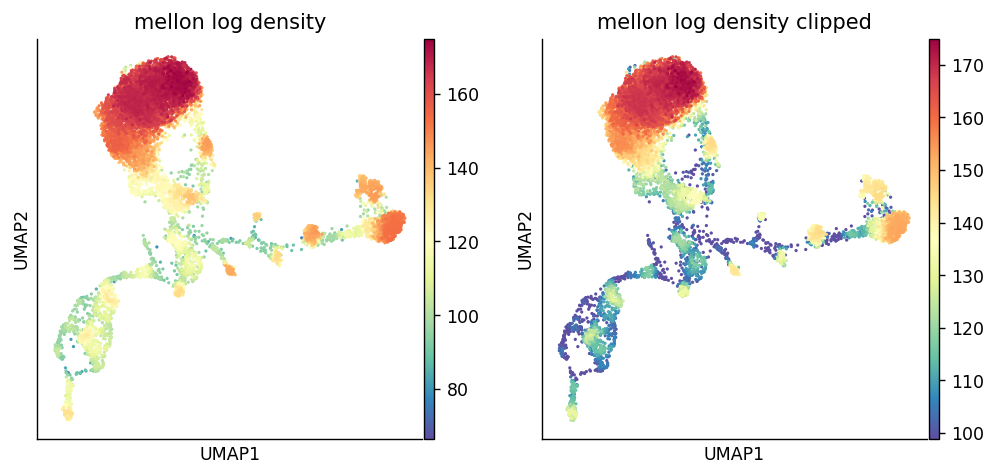

In [14]:
sc.pl.scatter(
    ad, color=["mellon_log_density", "mellon_log_density_clipped"], basis="umap"
)



---
# Step 4: Analysis



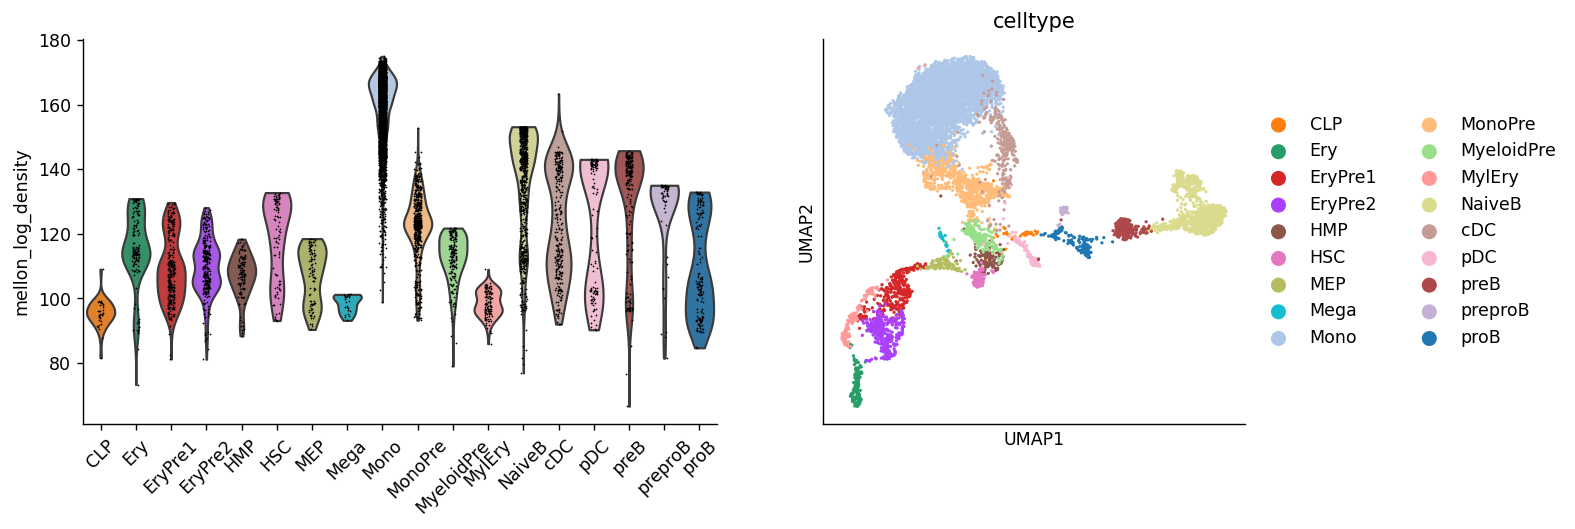

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[3, 2], figsize=[12, 4])
sc.pl.violin(ad, "mellon_log_density", "celltype", rotation=45, ax=ax1, show=False)
sc.pl.scatter(ad, color="celltype", basis="umap", ax=ax2, show=False)
plt.show()

In [17]:
ad.obs["palantir_pseudotime"], ad.obsm["palantir_lineage_cells"]

(IM-1393_BoneMarrow_TcellDep_1_multiome#GTGAGCGAGTCTCACC-1    0.138621
 IM-1393_BoneMarrow_TcellDep_1_multiome#GAGTCAAAGTCCTTCA-1    0.336803
 IM-1393_BoneMarrow_TcellDep_1_multiome#TGTGCGCAGTCGCTAG-1    0.684445
 IM-1393_BoneMarrow_TcellDep_1_multiome#ATATGTCCAATGCCTA-1    0.311772
 IM-1393_BoneMarrow_TcellDep_1_multiome#CTTAGTTTCGCTAGTG-1    0.704443
                                                                ...   
 IM-1393_BoneMarrow_TcellDep_2_multiome#ATCCGTGAGGGATTAG-1    0.309793
 IM-1393_BoneMarrow_TcellDep_2_multiome#ATTTAGGTCAGGTTTA-1    0.306938
 IM-1393_BoneMarrow_TcellDep_2_multiome#GATGGACAGATAAAGC-1    0.311873
 IM-1393_BoneMarrow_TcellDep_2_multiome#GAAGGCTAGCTATATG-1    0.312016
 IM-1393_BoneMarrow_TcellDep_2_multiome#AGACAATAGGCTCATG-1    0.311489
 Name: palantir_pseudotime, Length: 8627, dtype: float64,
                                                     NaiveB    Ery    pDC  \
 IM-1393_BoneMarrow_TcellDep_1_multiome#GTGAGCGA...   False  False  False   
 IM-139

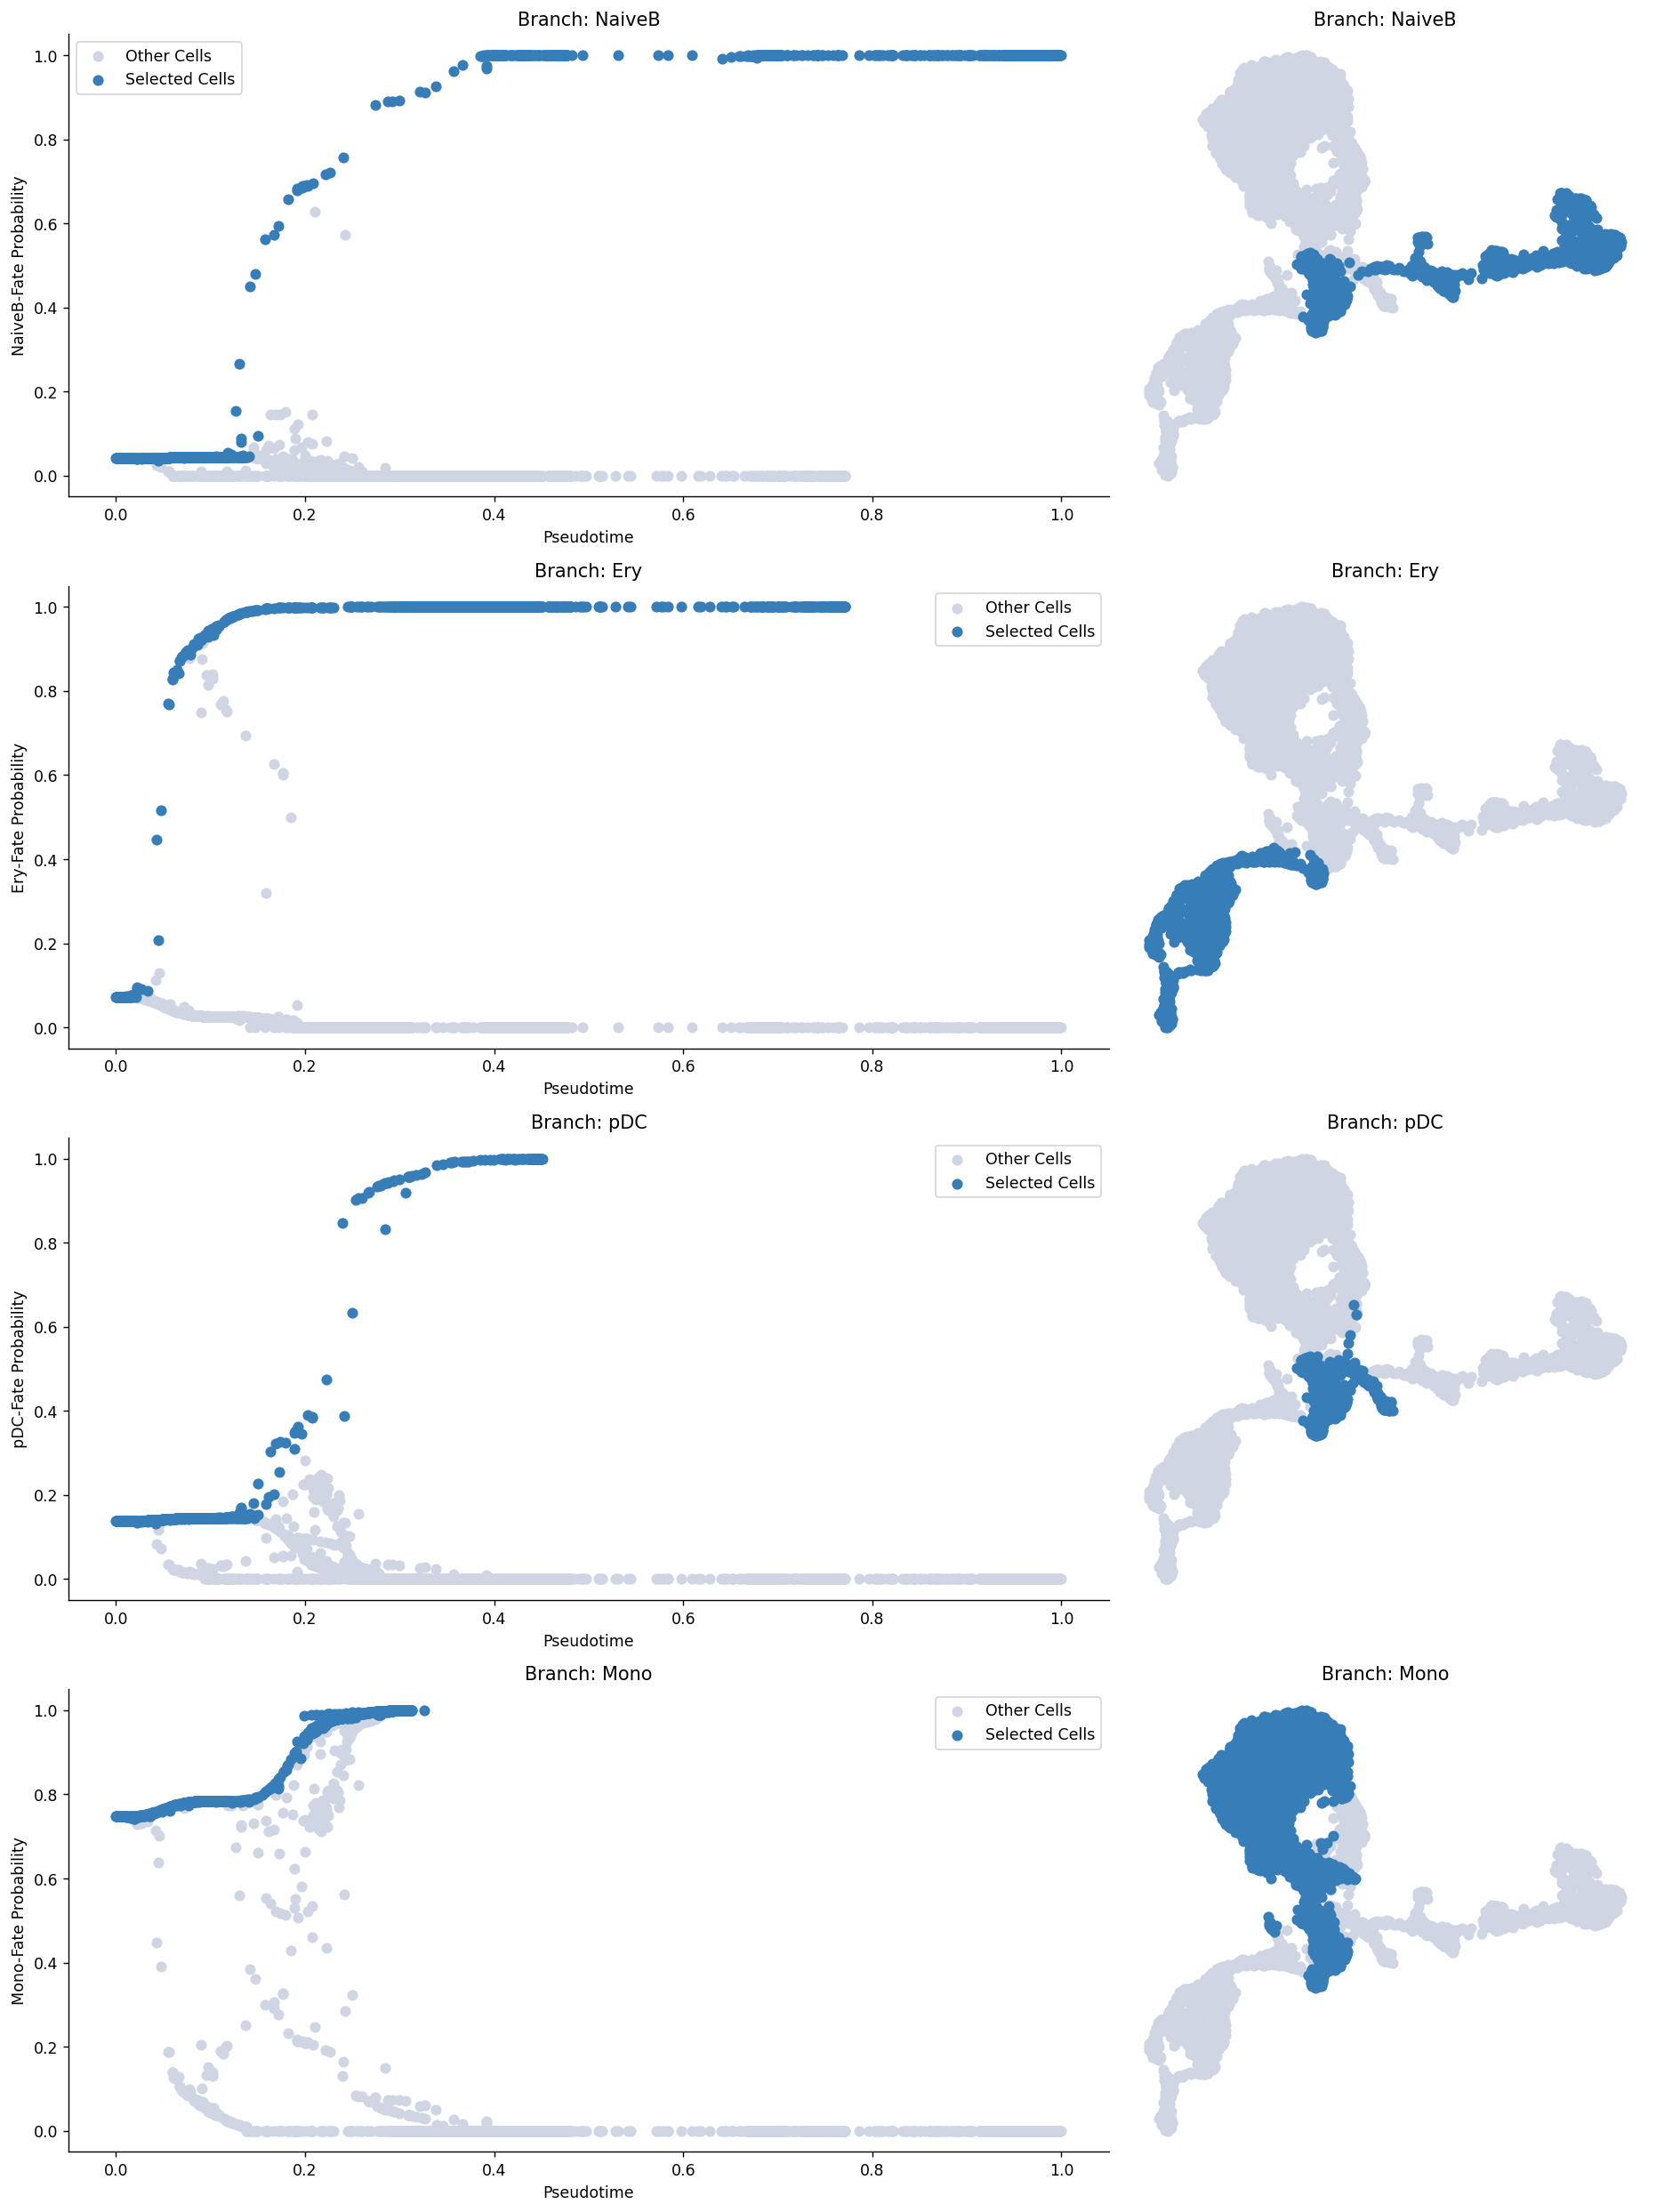

In [28]:
palantir.plot.plot_branch_selection(ad)
plt.show()

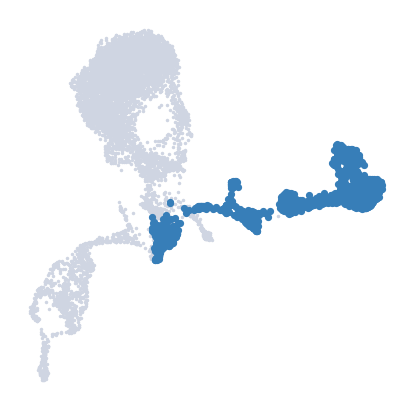

In [20]:
bcell_lineage_cells = ad.obs_names[ad.obsm["palantir_lineage_cells"]["NaiveB"]]

palantir.plot.highlight_cells_on_umap(ad, bcell_lineage_cells)
plt.show()

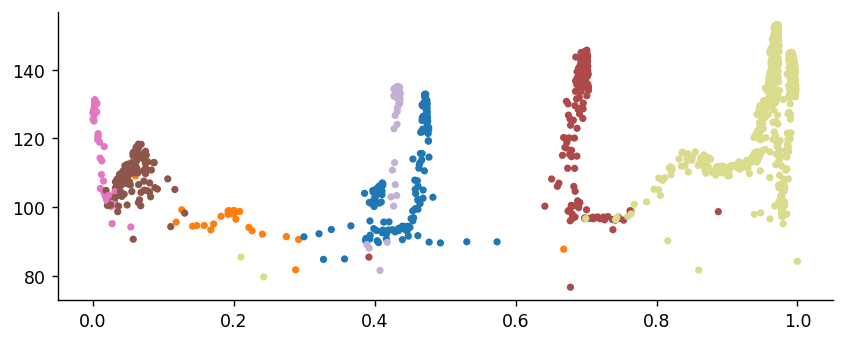

In [21]:
import pandas as pd

ct_colors = pd.Series(
    ad.uns["celltype_colors"], index=ad.obs["celltype"].values.categories
)

plt.figure(figsize=[8, 3])
plt.scatter(
    ad.obs["palantir_pseudotime"][bcell_lineage_cells],
    ad.obs["mellon_log_density"][bcell_lineage_cells],
    s=10,
    color=ct_colors[ad.obs["celltype"][bcell_lineage_cells]],
)
plt.show()

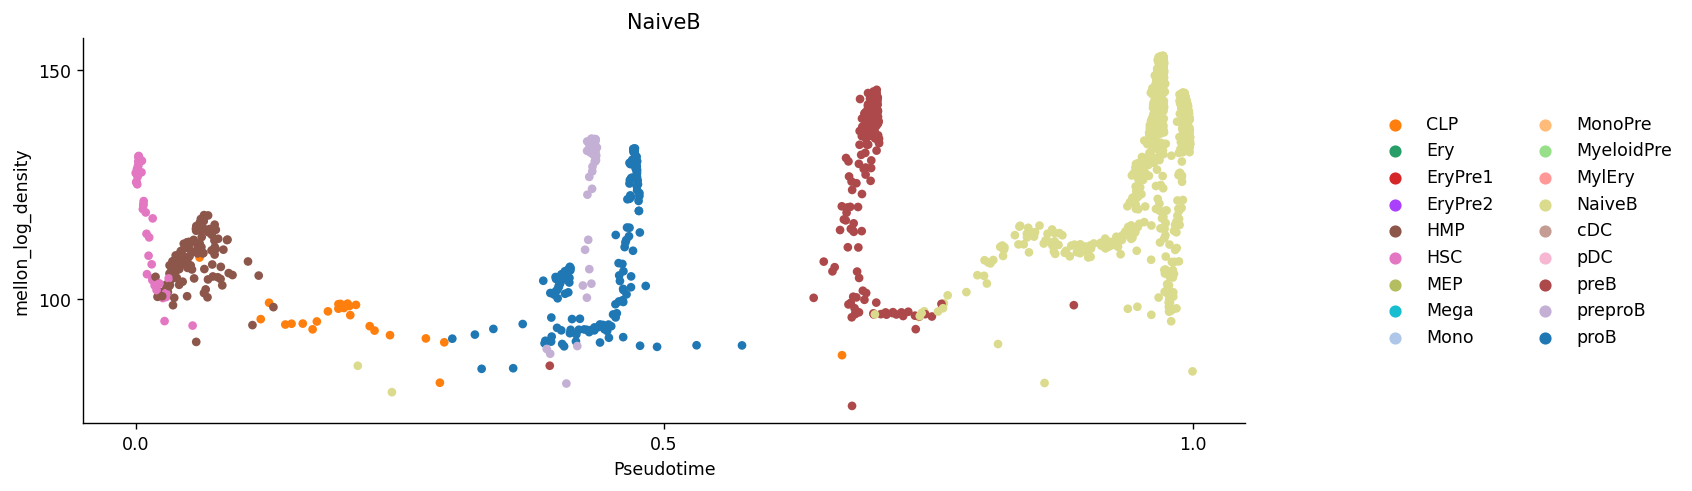

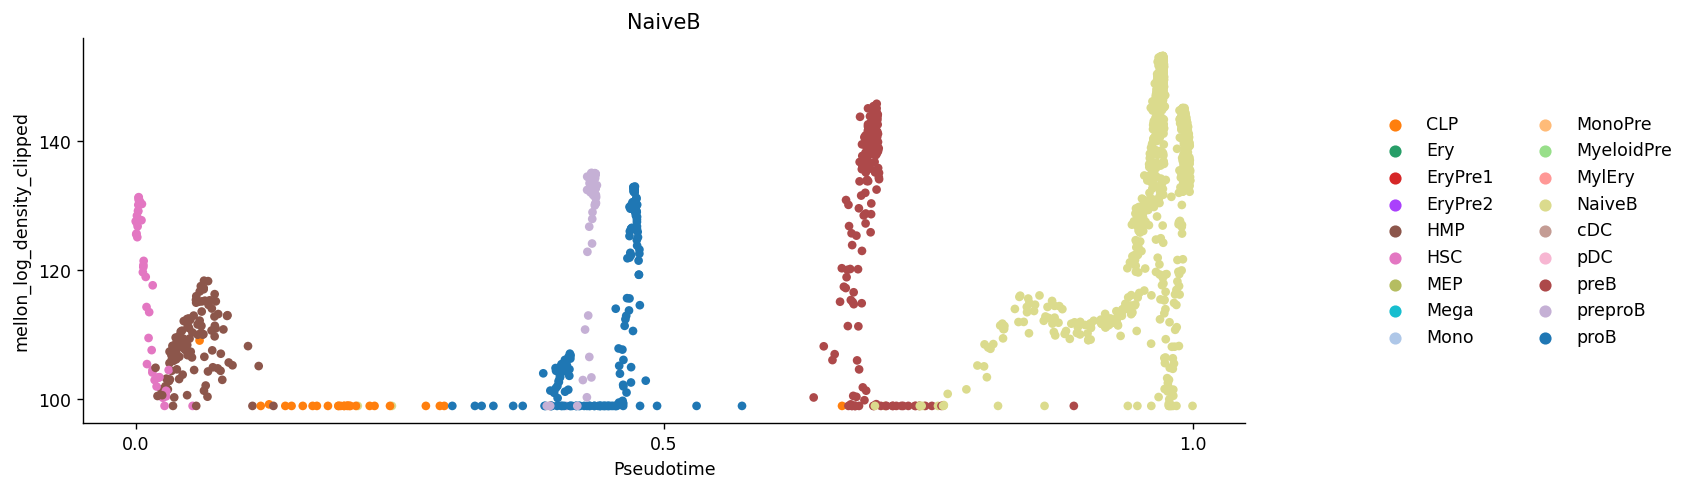

In [25]:
palantir.plot.plot_branch(
    ad,
    branch_name="NaiveB",
    position="mellon_log_density",
    color="celltype",
    masks_key="palantir_lineage_cells",
    s=100,
)
plt.show()
palantir.plot.plot_branch(
    ad,
    branch_name="NaiveB",
    position="mellon_log_density_clipped",
    color="celltype",
    masks_key="palantir_lineage_cells",
    s=100,
)
plt.show()

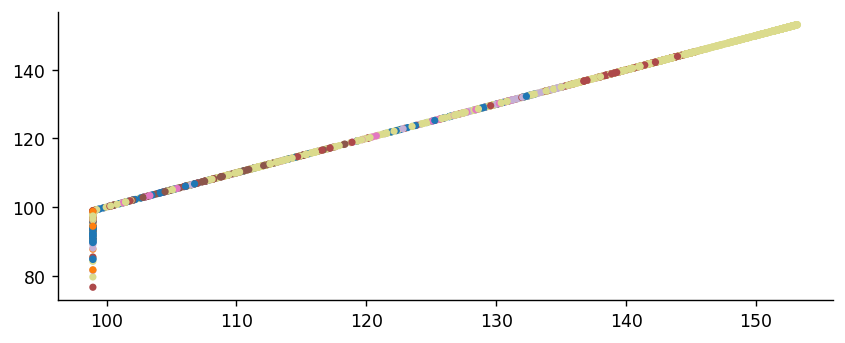

In [26]:
import pandas as pd

ct_colors = pd.Series(
    ad.uns["celltype_colors"], index=ad.obs["celltype"].values.categories
)

plt.figure(figsize=[8, 3])
plt.scatter(
    ad.obs["mellon_log_density_clipped"][bcell_lineage_cells],
    ad.obs["mellon_log_density"][bcell_lineage_cells],
    s=10,
    color=ct_colors[ad.obs["celltype"][bcell_lineage_cells]],
)
plt.show()

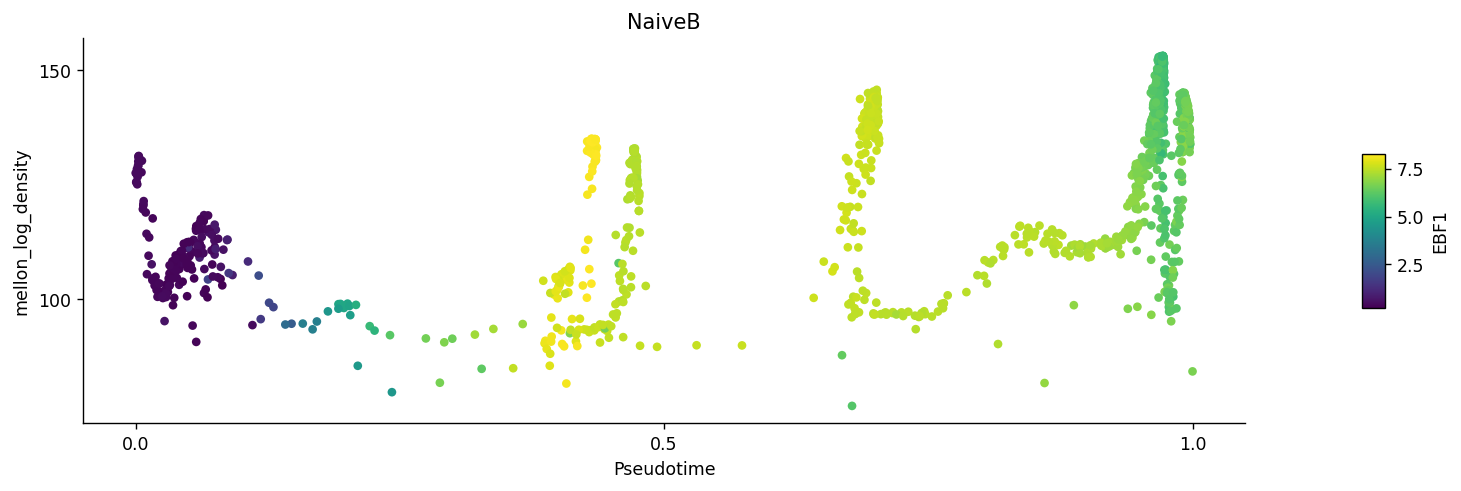

In [27]:
# Plot imputed expression of EBF1 in the comparison between pseudotime and log density
palantir.plot.plot_branch(
    ad,
    branch_name="NaiveB",
    position="mellon_log_density",
    color="EBF1",
    color_layer="MAGIC_imputed_data",
    masks_key="palantir_lineage_cells",
    s=100,
)
plt.show()

In [29]:
# Local variability of genes
palantir.utils.run_local_variability(ad)

# This will add `local_variability` as a layer to anndata
ad

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells'
    varm: 'PCs', 'geneXTF'
    layers: 'Bcells_lineage_specific', 'Bcells_primed', 'MAGIC_imputed_data', 'local_variability'
    obsp: 'DM_Kernel', 'DM_Similarity', 'connectivitie

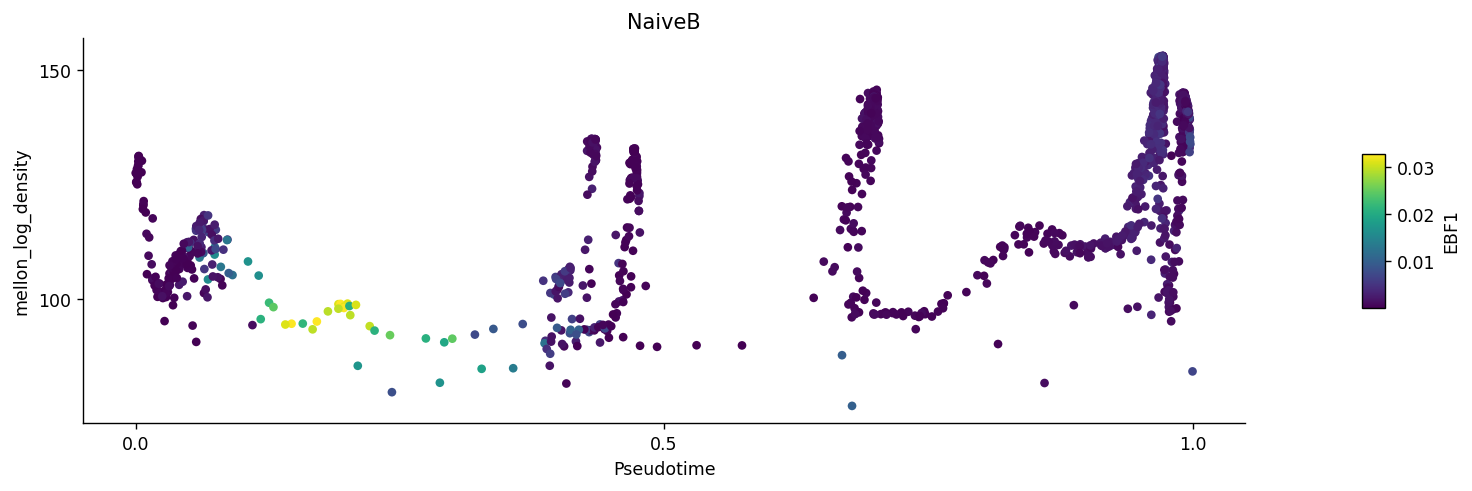

In [30]:
# Local variability or local change can also be visualized using `plot_branch` function
palantir.plot.plot_branch(
    ad,
    branch_name="NaiveB",
    position="mellon_log_density",
    color="EBF1",
    color_layer="local_variability",
    masks_key="palantir_lineage_cells",
    s=100,
)
plt.show()

In [40]:
!pip install --q matplotlib

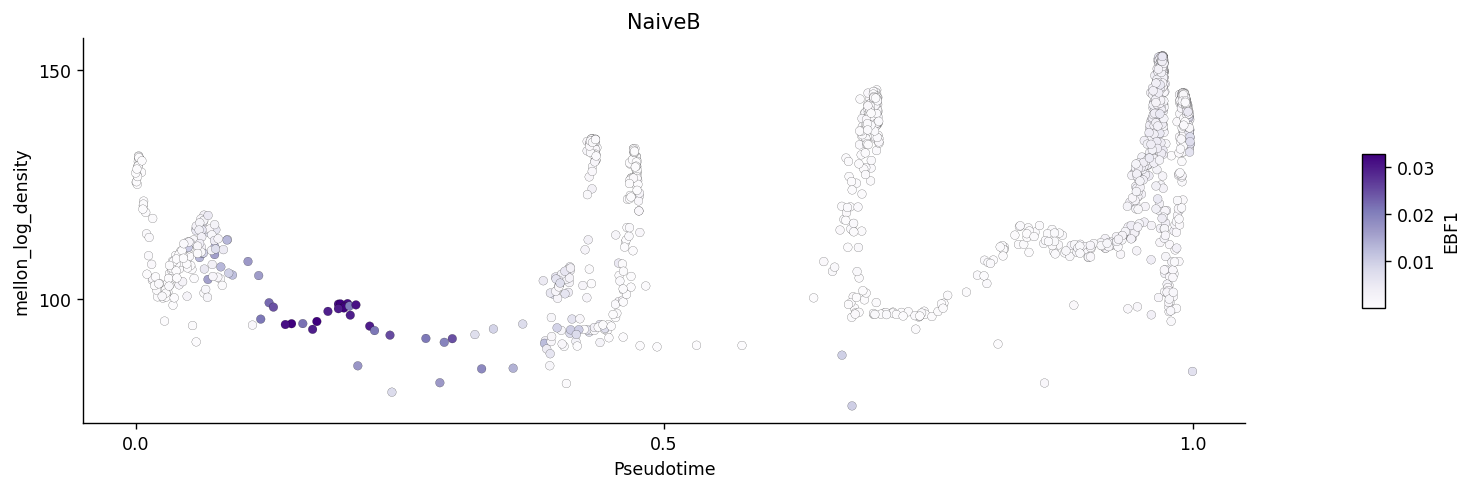

In [48]:
# In the Mellon manuscript, they use the Blues colormap for plotting changes
palantir.plot.plot_branch(
    ad,
    branch_name="NaiveB",
    position="mellon_log_density",
    color="EBF1",
    color_layer="local_variability",
    masks_key="palantir_lineage_cells",
    s=100,
    cmap="Purples",
    edgecolor="black",
    linewidth=0.1,
)
plt.show()

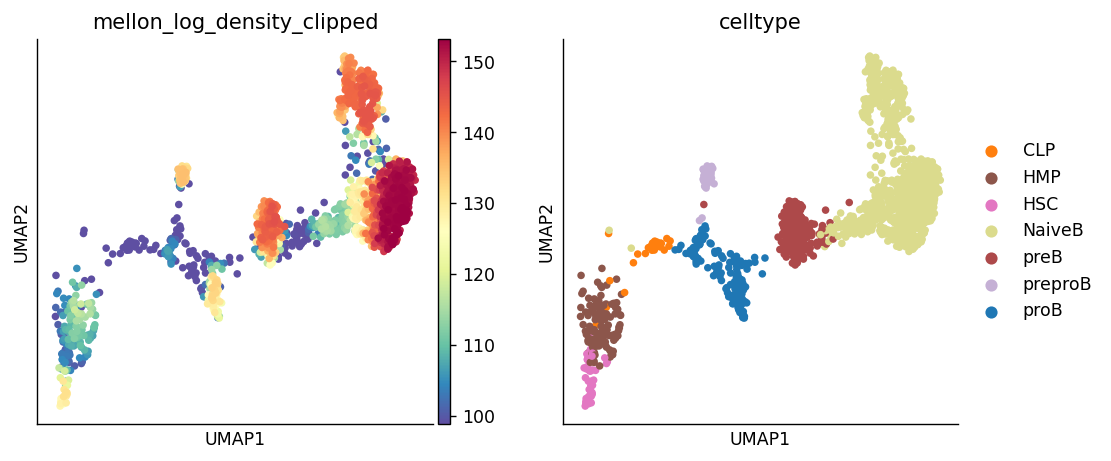

In [49]:
# UMAPs can be plotted with subsets of cells to explore densiies
sc.pl.embedding(
    ad[bcell_lineage_cells],
    basis="umap",
    color=["mellon_log_density_clipped", "celltype"],
)



---

# Calculate gene trends

In [51]:
selection = ad.obsm["palantir_lineage_cells"]["NaiveB"]
pseudotimes = ad[selection, :].obs["palantir_pseudotime"]
expressions = ad[selection, :].X
pseudotim_grid = np.linspace(pseudotimes.min(), pseudotimes.max(), 200)

In [52]:
%%time
model = mellon.FunctionEstimator(ls=5, sigma=1)
trends = model.fit_predict(pseudotimes, expressions, pseudotim_grid)
ad.varm["custom_mellon_trends_NaiveB"] = trends.T
ad.uns["custom_mellon_trends_NaiveB_pseudotime"] = pseudotim_grid

[2024-06-29 05:50:58,218] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (1,582) >= n_samples (1,582) and rank = 1.0.
[2024-06-29 05:50:58,220] [INFO    ] Using covariance function Matern52(ls=5.0).
[2024-06-29 05:50:58,265] [INFO    ] Recomputing covariance decomposition for predictive function.
CPU times: user 16.4 s, sys: 4.47 s, total: 20.9 s
Wall time: 17.8 s


In [53]:
%%time
trends = palantir.presults.compute_gene_trends(
    ad, masks_key="palantir_lineage_cells"
)

NaiveB
[2024-06-29 05:51:50,174] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (1,582) and rank = 1.0.
[2024-06-29 05:51:50,175] [INFO    ] Using covariance function Matern52(ls=1.0).
Ery
[2024-06-29 05:51:56,436] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (947) and rank = 1.0.
[2024-06-29 05:51:56,438] [INFO    ] Using covariance function Matern52(ls=1.0).
pDC
[2024-06-29 05:52:02,061] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (485) and rank = 1.0.
[2024-06-29 05:52:02,063] [INFO    ] Using covariance function Matern52(ls=1.0).
Mono
[2024-06-29 05:52:06,950] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (5,645) and rank = 1.0.
[2024-06-29 05:52:06,952] [INFO    ] Using covariance function Matern52(ls=1.0).
CPU times: user 34.8 s, sys: 9.73 s, total: 44.5 s
Wall time: 30.7 s


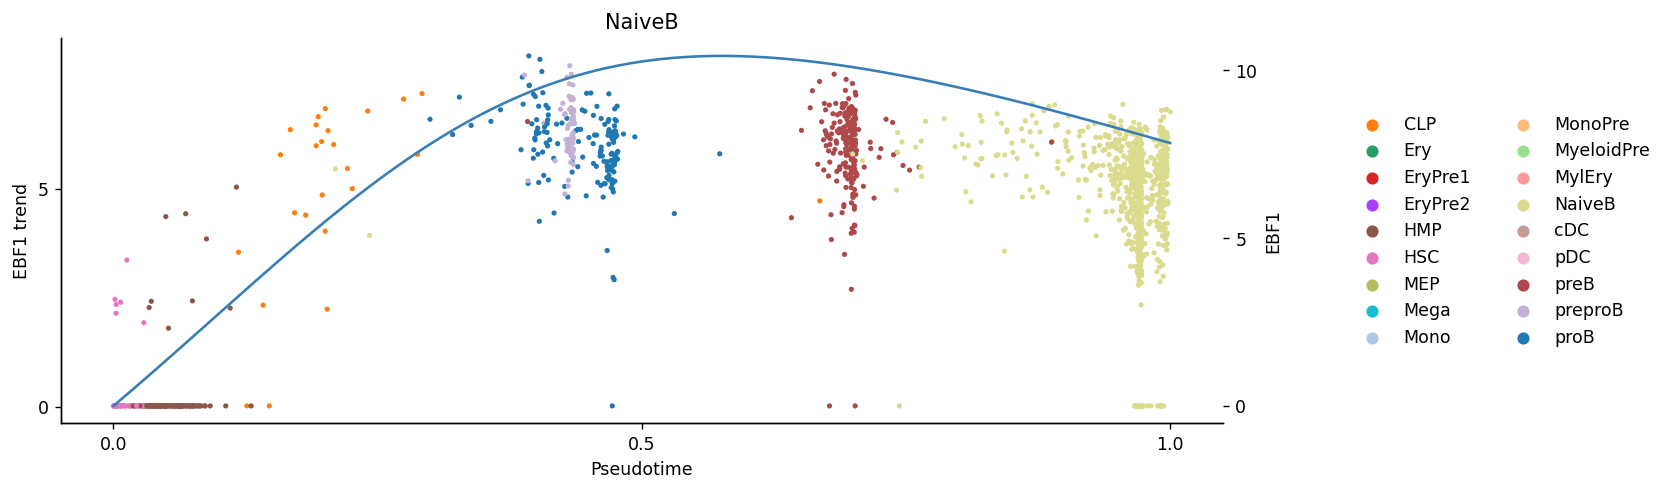

In [55]:
palantir.plot.plot_trend(
    ad, "NaiveB", "EBF1", masks_key="palantir_lineage_cells", color="celltype"
)
plt.show()

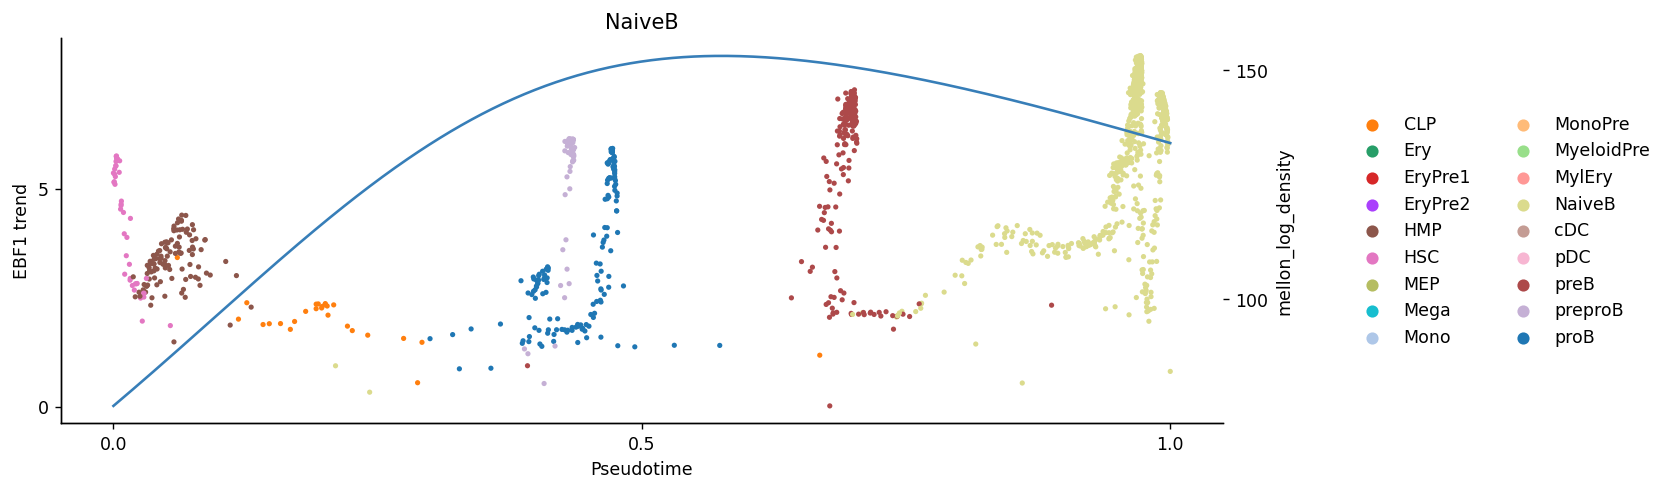

In [56]:
palantir.plot.plot_trend(
    ad,
    "NaiveB",
    "EBF1",
    masks_key="palantir_lineage_cells",
    color="celltype",
    position="mellon_log_density",
)
plt.show()

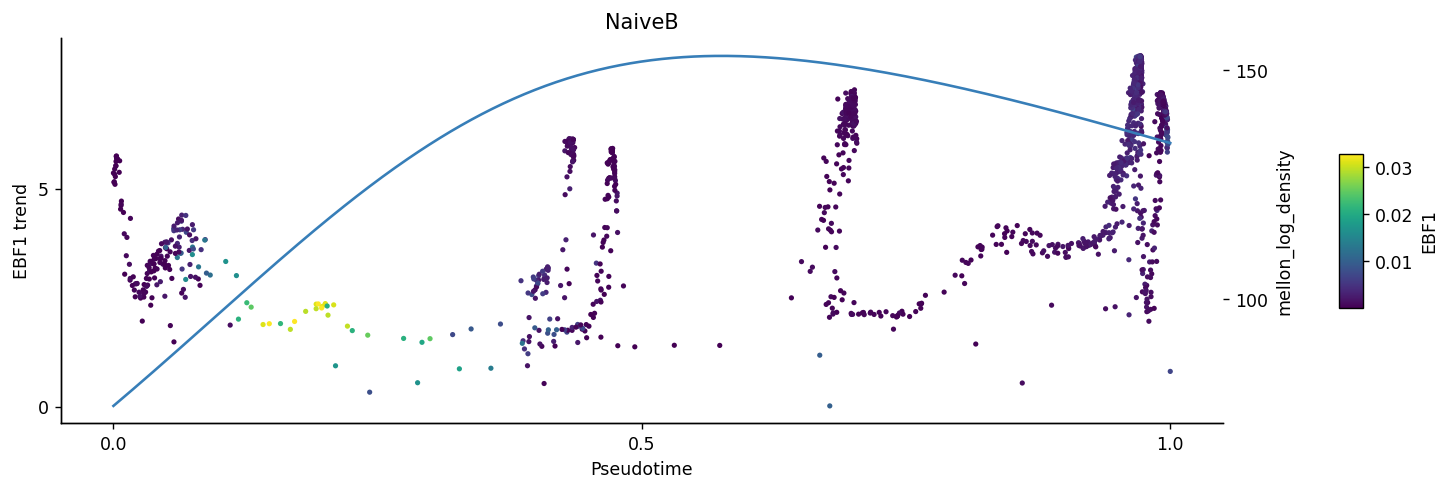

In [57]:
palantir.utils.run_local_variability(ad)
palantir.plot.plot_trend(
    ad,
    "NaiveB",
    "EBF1",
    masks_key="palantir_lineage_cells",
    color="EBF1",
    position="mellon_log_density",
    color_layer="local_variability",
)
plt.show()



---
# Cell selection for computing gene change scores


In [58]:
ad.obsm["palantir_lineage_cells"]

,NaiveB,Ery,pDC,Mono
IM-1393_BoneMarrow_TcellDep_1_multiome#GTGAGCGAGTCTCACC-1,False,False,False,True
IM-1393_BoneMarrow_TcellDep_1_multiome#GAGTCAAAGTCCTTCA-1,False,True,False,False
IM-1393_BoneMarrow_TcellDep_1_multiome#TGTGCGCAGTCGCTAG-1,False,True,False,False
IM-1393_BoneMarrow_TcellDep_1_multiome#ATATGTCCAATGCCTA-1,False,False,False,True
IM-1393_BoneMarrow_TcellDep_1_multiome#CTTAGTTTCGCTAGTG-1,False,True,False,False
...,...,...,...,...
IM-1393_BoneMarrow_TcellDep_2_multiome#ATCCGTGAGGGATTAG-1,False,False,False,True
IM-1393_BoneMarrow_TcellDep_2_multiome#ATTTAGGTCAGGTTTA-1,False,False,False,True
IM-1393_BoneMarrow_TcellDep_2_multiome#GATGGACAGATAAAGC-1,False,False,False,True
IM-1393_BoneMarrow_TcellDep_2_multiome#GAAGGCTAGCTATATG-1,False,False,False,True


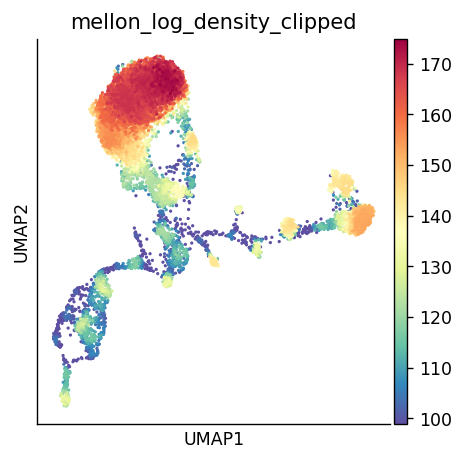

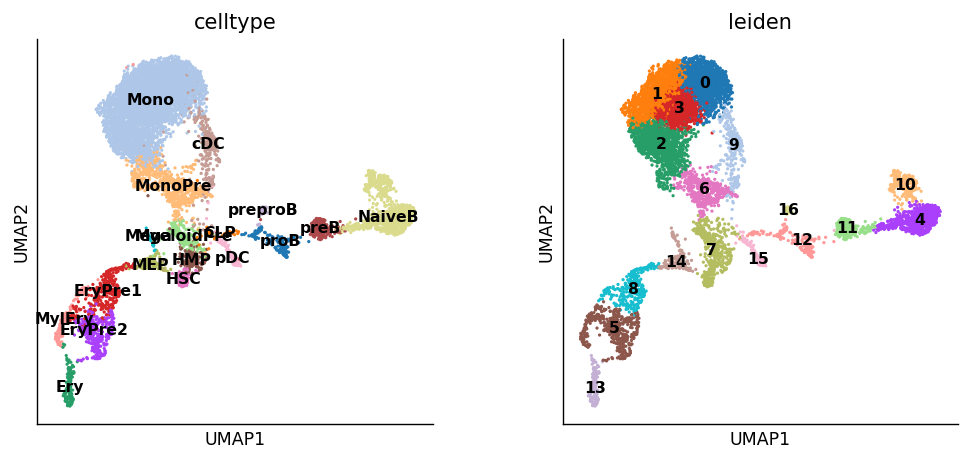

In [59]:
sc.pl.embedding(ad, basis="umap", color=["mellon_log_density_clipped"])
sc.pl.embedding(
    ad,
    basis="umap",
    color=["celltype", "leiden"],
    legend_loc="on data",
    legend_fontsize=9,
)
plt.show()

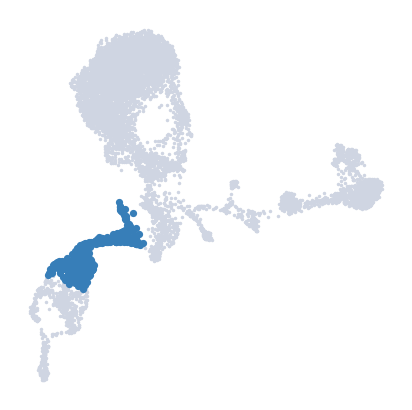

In [60]:
cells = ad.obs_names[ad.obs["leiden"].isin(["8", "14"])]
palantir.plot.highlight_cells_on_umap(ad, cells)
plt.show()

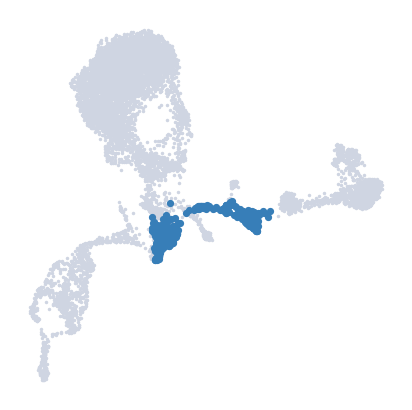

In [65]:
bcell_specification_cells = (
    ad.obs["celltype"].isin(["HSC", "HMP", "CLP", "proB"])
    & ad.obsm["palantir_lineage_cells"]["NaiveB"]
)
ad.obsm["specification"] = pd.DataFrame({"Bcells": bcell_specification_cells})

# Verify that the selected set of cells is correct
palantir.plot.highlight_cells_on_umap(ad, bcell_specification_cells)
plt.show()

In [63]:
# 1. Re-computing density with low intrinsic dimensionality to make sure weights are representative
dm_res = palantir.utils.run_diffusion_maps(ad, pca_key="X_pca", n_components=20)
model = mellon.DensityEstimator(d_method="fractal")
log_density = model.fit_predict(ad.obsm["DM_EigenVectors"])

ad.obs["mellon_log_density_lowd"] = log_density

[2024-06-29 06:05:03,059] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (8,627) and rank = 1.0.
[2024-06-29 06:05:03,062] [INFO    ] Computing nearest neighbor distances.
[2024-06-29 06:05:07,672] [INFO    ] Using d=1.7675323505679448.
[2024-06-29 06:05:07,706] [INFO    ] Using covariance function Matern52(ls=0.008487235728612248).
[2024-06-29 06:05:07,711] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2024-06-29 06:05:41,553] [INFO    ] Using rank 5,000 covariance representation.
[2024-06-29 06:05:52,759] [INFO    ] Running inference using L-BFGS-B.


In [66]:
# 2. Computing scores for each gene
score_key = "change_scores"
palantir.utils.run_low_density_variability(
    ad,
    cell_mask="specification",
    density_key="mellon_log_density_lowd",
    score_key=score_key,
)
plt.show()

In [67]:
scores = ad.var["change_scores_Bcells"]
scores.sort_values(ascending=False)

DIAPH3        9.150981e-04
EBF1          8.642699e-04
NEGR1         7.812832e-04
ERG           7.385981e-04
AL589693.1    7.276913e-04
                  ...     
SPTBN5        3.524415e-11
AC097504.2    2.371954e-11
AC110741.1    1.811624e-11
BTNL8         7.228772e-13
AC138207.5    0.000000e+00
Name: change_scores_Bcells, Length: 17226, dtype: float64

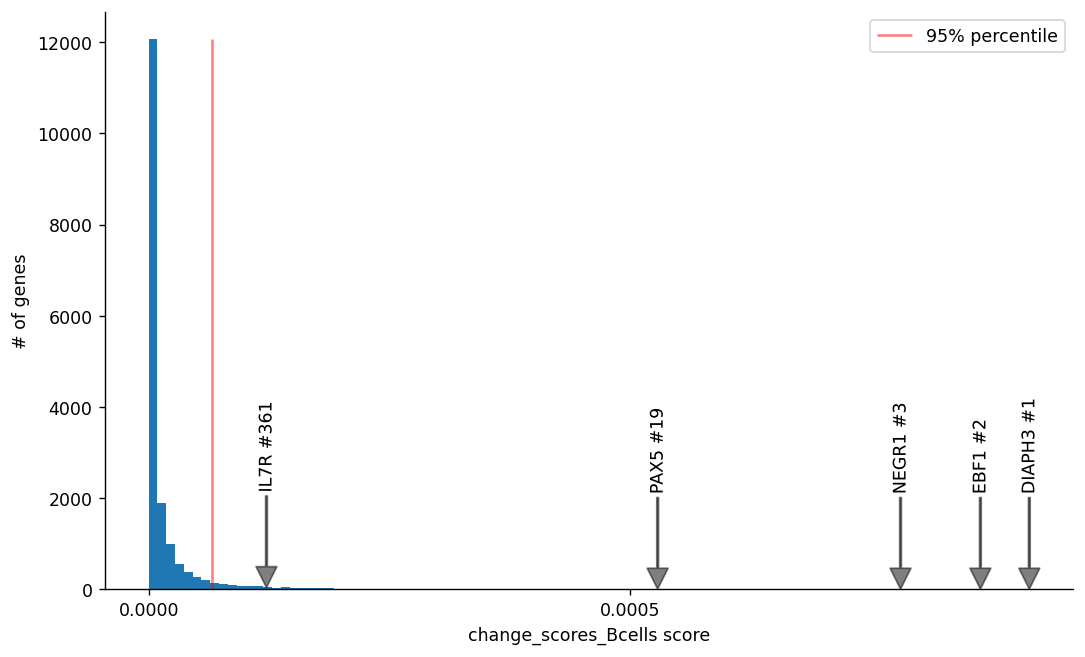

In [70]:
# The scores can be visualized as a histogram. Some important genes are highlgited below
highlight_gene = ["EBF1", "PAX5", "IL7R", "NEGR1", "DIAPH3"]

palantir.plot.gene_score_histogram(ad, "change_scores_Bcells", highlight_gene)
plt.show()

In [71]:
percentile = 0.95
percentile_cutoff = np.quantile(scores, percentile)
scores = scores.sort_values(ascending=False)
bcell_change_genes = scores.index[scores >= percentile_cutoff]

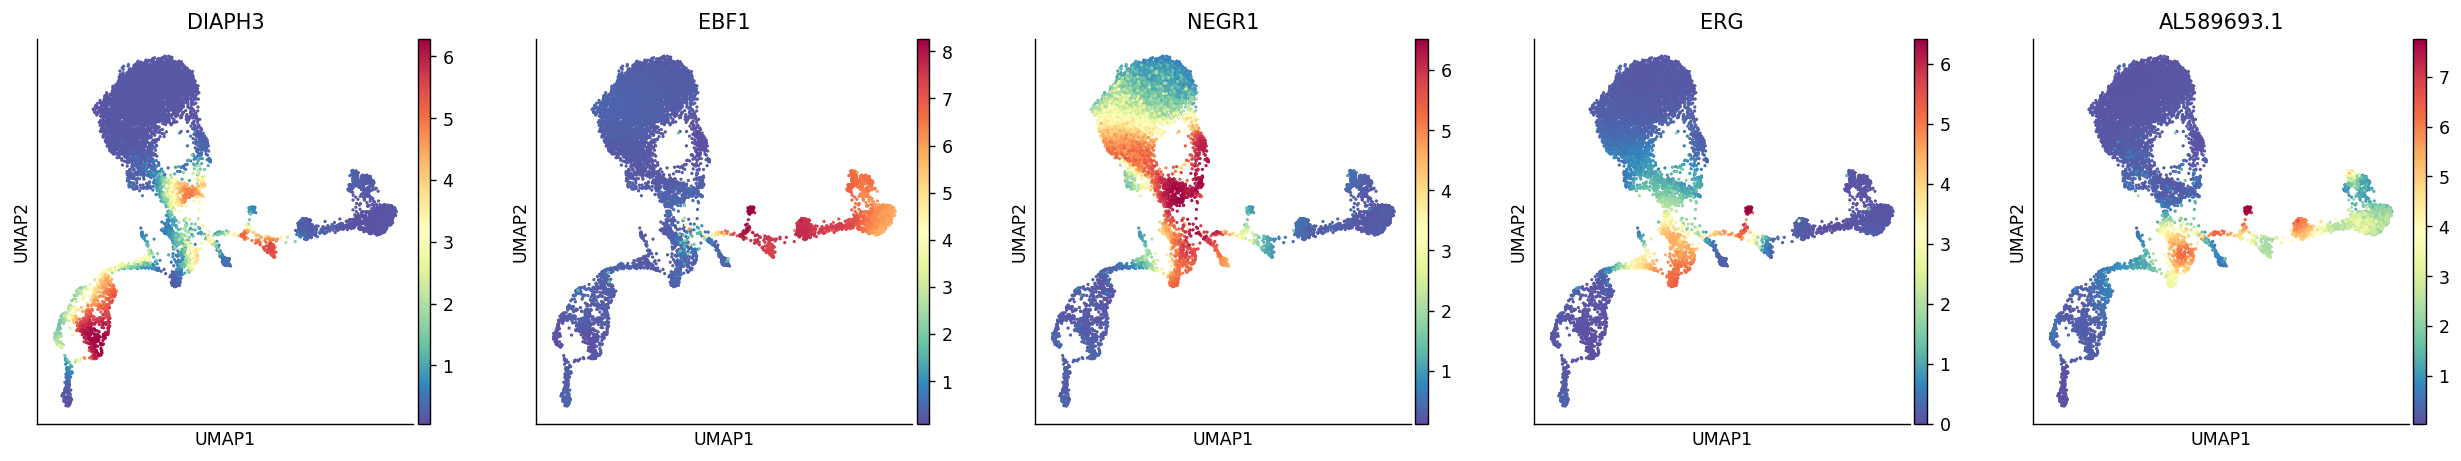

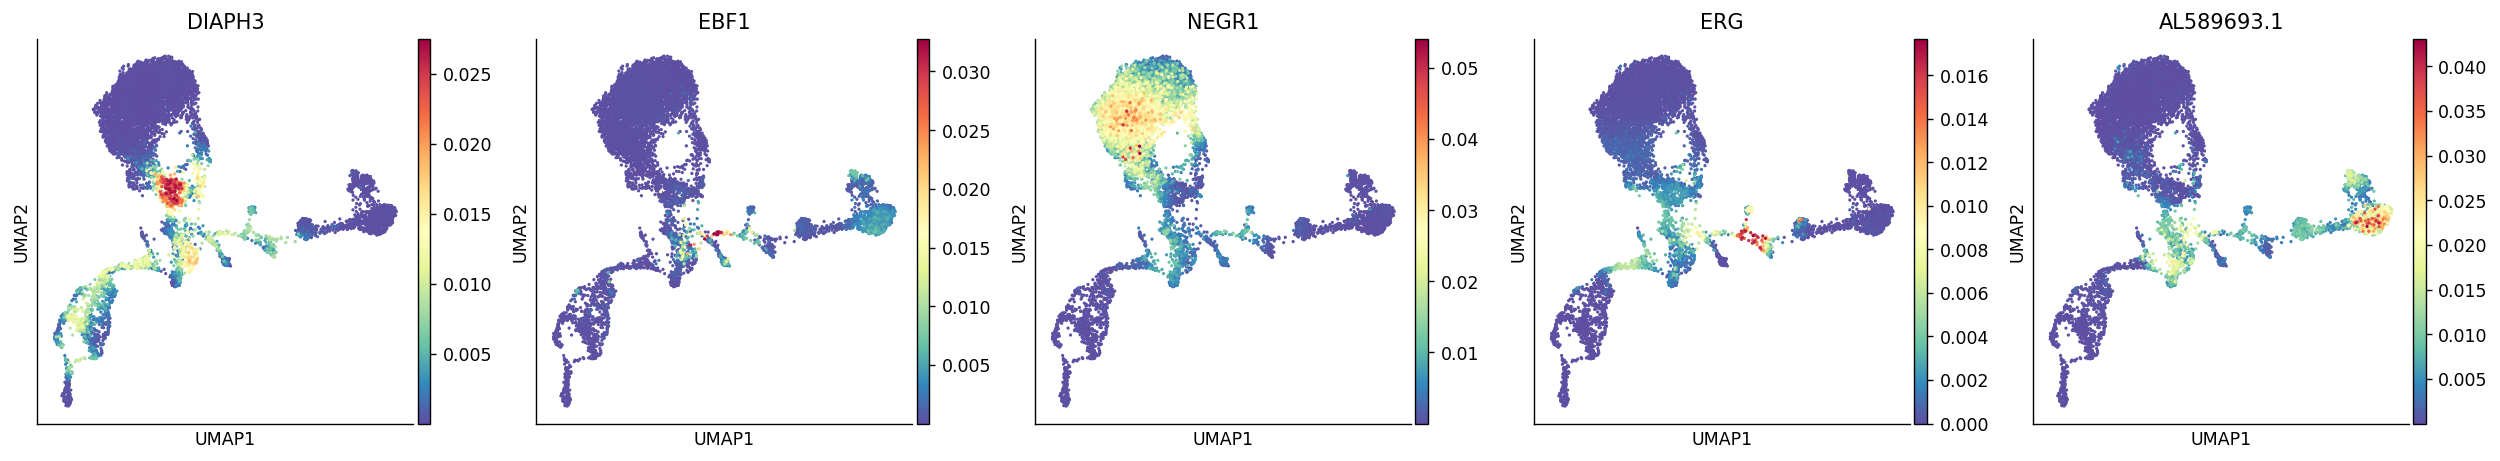

In [72]:
# Visualize the expression and variability of top 5 genes
sc.pl.embedding(
    ad,
    basis="umap",
    color=bcell_change_genes[:5],
    layer="MAGIC_imputed_data",
    ncols=5,
)
sc.pl.embedding(
    ad,
    basis="umap",
    color=bcell_change_genes[:5],
    layer="local_variability",
    ncols=5,
)
plt.show()

In [75]:
_ = palantir.presults.compute_gene_trends(ad, ls=5, masks_key="specification")

Bcells
[2024-06-29 06:20:07,412] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (500) >= n_samples (335) and rank = 1.0.
[2024-06-29 06:20:07,414] [INFO    ] Using covariance function Matern52(ls=5.0).


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


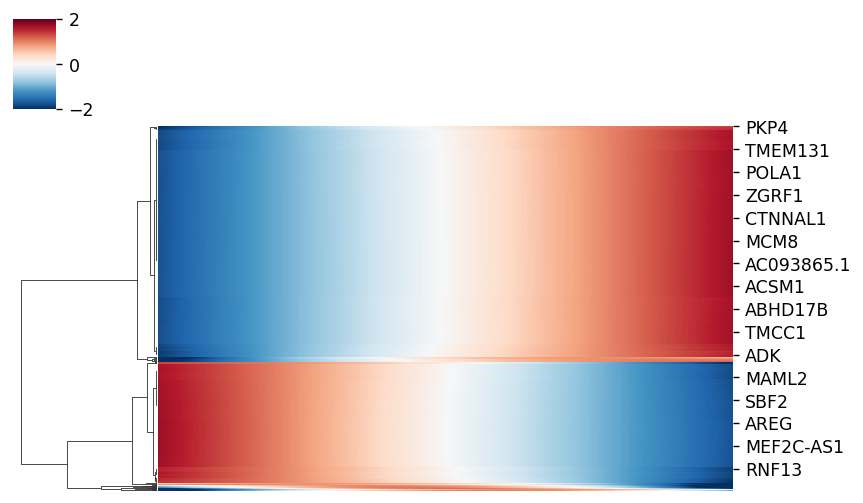

In [77]:
# Plot
import seaborn as sns

selected_trends = ad.varm["gene_trends_Bcells"].loc[bcell_change_genes, :]

sns.clustermap(
    selected_trends,
    z_score=0,
    cmap="RdBu_r",
    col_cluster=False,
    vmin=-2,
    vmax=2,
    figsize=[7, 4],
    xticklabels=0,
)
plt.show()

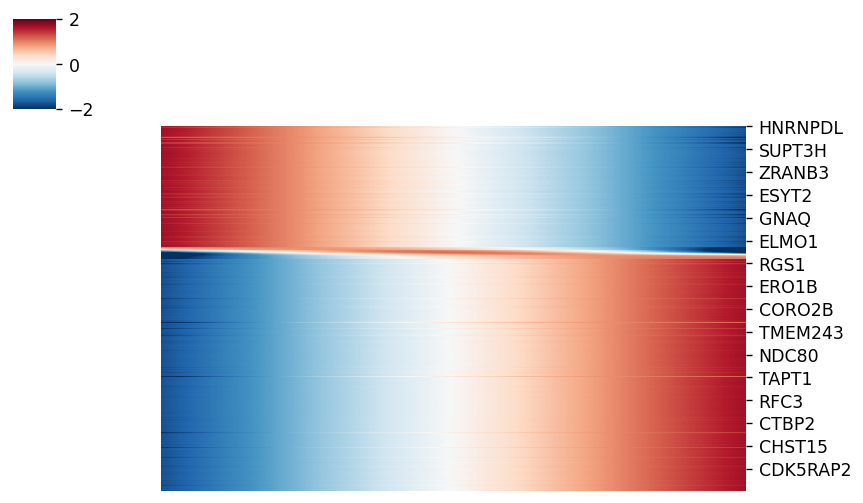

In [78]:
# Alternatively sort by maximum exprression bin for clean visualization
plot_order = selected_trends.idxmax(axis=1).sort_values().index
sns.clustermap(
    selected_trends.loc[plot_order, :],
    z_score=0,
    cmap="RdBu_r",
    col_cluster=False,
    row_cluster=False,
    vmin=-2,
    vmax=2,
    figsize=[7, 4],
    xticklabels=0,
)
plt.show()

In [79]:
ad

AnnData object with n_obs × n_vars = 8627 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'phenograph', 'log_n_counts', 'celltype', 'palantir_pseudotime', 'selection', 'NaiveB_lineage', 'mellon_log_density', 'mellon_log_density_clipped', 'mellon_log_density_lowd'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'PeakCounts', 'change_scores_Bcells'
    uns: 'DMEigenValues', 'DM_EigenValues', 'NaiveB_lineage_colors', 'celltype_colors', 'custom_branch_mask_columns', 'hvg', 'leiden', 'mellon_log_density_predictor', 'neighbors', 'pca', 'sample_colors', 'umap', 'custom_mellon_trends_NaiveB_pseudotime', 'leiden_colors'
    obsm: 'DM_EigenVectors', 'X_FDL', 'X_pca', 'X_umap', 'branch_masks', 'chromVAR_deviations', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells', 'specification'
    varm: 'PCs', 'geneXTF', 'custom_mellon_trends_Na

In [80]:
selected_trends.loc[plot_order, :]

,0.0,0.0013393566388719236,0.002678713277743847,0.00401806991661577,0.005357426555487694,0.006696783194359618,0.00803613983323154,0.009375496472103464,0.010714853110975388,0.012054209749847312,...,0.6562847530472425,0.6576241096861145,0.6589634663249864,0.6603028229638583,0.6616421796027302,0.6629815362416022,0.6643208928804741,0.665660249519346,0.666999606158218,0.6683389627970898
HNRNPDL,3.052415,3.051697,3.050978,3.050259,3.049539,3.048819,3.048099,3.047377,3.046656,3.045934,...,2.654708,2.653832,2.652955,2.652079,2.651203,2.650326,2.649450,2.648573,2.647696,2.646819
C1orf21,2.124744,2.123519,2.122294,2.121068,2.119842,2.118616,2.117389,2.116162,2.114934,2.113706,...,1.497813,1.496523,1.495233,1.493944,1.492654,1.491365,1.490076,1.488786,1.487497,1.486209
RAB11FIP1,1.220019,1.219962,1.219905,1.219848,1.219791,1.219734,1.219676,1.219618,1.219561,1.219503,...,1.176215,1.176096,1.175978,1.175859,1.175740,1.175621,1.175501,1.175382,1.175263,1.175143
SMAD1,1.311993,1.311838,1.311684,1.311530,1.311375,1.311220,1.311065,1.310910,1.310754,1.310598,...,1.215822,1.215591,1.215359,1.215127,1.214896,1.214664,1.214432,1.214199,1.213967,1.213735
FRMD4B,2.656397,2.654222,2.652047,2.649872,2.647695,2.645518,2.643341,2.641162,2.638983,2.636804,...,1.548871,1.546607,1.544342,1.542078,1.539814,1.537550,1.535287,1.533024,1.530762,1.528499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RBMS3,0.136199,0.136685,0.137171,0.137658,0.138144,0.138630,0.139117,0.139603,0.140090,0.140576,...,0.370290,0.370743,0.371195,0.371646,0.372098,0.372550,0.373001,0.373452,0.373903,0.374354
IPO7,2.261201,2.261572,2.261942,2.262313,2.262683,2.263053,2.263422,2.263791,2.264160,2.264529,...,2.405631,2.405839,2.406046,2.406254,2.406461,2.406667,2.406874,2.407080,2.407285,2.407490
DGKH,0.992038,0.993392,0.994745,0.996098,0.997451,0.998805,1.000158,1.001512,1.002865,1.004219,...,1.638665,1.639904,1.641142,1.642379,1.643616,1.644853,1.646089,1.647324,1.648559,1.649794
MCM7,1.077389,1.079370,1.081352,1.083333,1.085315,1.087297,1.089279,1.091261,1.093244,1.095226,...,2.033526,2.035377,2.037228,2.039078,2.040927,2.042775,2.044623,2.046470,2.048317,2.050162


In [81]:
ad.varm["gene_trends_Bcells"]

,0.0,0.0013393566388719236,0.002678713277743847,0.00401806991661577,0.005357426555487694,0.006696783194359618,0.00803613983323154,0.009375496472103464,0.010714853110975388,0.012054209749847312,...,0.6562847530472425,0.6576241096861145,0.6589634663249864,0.6603028229638583,0.6616421796027302,0.6629815362416022,0.6643208928804741,0.665660249519346,0.666999606158218,0.6683389627970898
AL627309.1,0.009199,0.009181,0.009163,0.009145,0.009127,0.009110,0.009092,0.009074,0.009056,0.009038,...,0.000365,0.000347,0.000330,0.000312,0.000294,0.000277,0.000259,0.000241,0.000224,0.000206
AL627309.5,0.062016,0.061944,0.061871,0.061799,0.061727,0.061654,0.061582,0.061510,0.061437,0.061365,...,0.025400,0.025325,0.025251,0.025176,0.025102,0.025027,0.024953,0.024879,0.024804,0.024730
LINC01409,0.342980,0.342934,0.342887,0.342841,0.342794,0.342748,0.342701,0.342655,0.342608,0.342561,...,0.314791,0.314724,0.314657,0.314590,0.314523,0.314456,0.314389,0.314322,0.314256,0.314189
LINC01128,0.198832,0.199076,0.199320,0.199563,0.199807,0.200050,0.200294,0.200538,0.200781,0.201025,...,0.315467,0.315690,0.315914,0.316138,0.316361,0.316585,0.316808,0.317031,0.317254,0.317477
LINC00115,0.105146,0.105080,0.105013,0.104947,0.104880,0.104814,0.104747,0.104681,0.104614,0.104548,...,0.071541,0.071473,0.071404,0.071336,0.071267,0.071199,0.071131,0.071062,0.070994,0.070925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,2.977895,2.976599,2.975302,2.974004,2.972706,2.971407,2.970107,2.968807,2.967507,2.966206,...,2.298956,2.297531,2.296106,2.294681,2.293256,2.291831,2.290407,2.288982,2.287557,2.286132
MT-CYB,8.562322,8.561343,8.560362,8.559380,8.558396,8.557412,8.556426,8.555439,8.554451,8.553462,...,7.959171,7.957733,7.956293,7.954853,7.953413,7.951972,7.950530,7.949087,7.947644,7.946200
MAFIP,0.247262,0.246917,0.246571,0.246226,0.245880,0.245534,0.245188,0.244842,0.244496,0.244150,...,0.074109,0.073761,0.073413,0.073064,0.072716,0.072368,0.072020,0.071672,0.071324,0.070976
AL354822.1,0.090939,0.090854,0.090768,0.090682,0.090596,0.090510,0.090424,0.090338,0.090252,0.090166,...,0.048379,0.048294,0.048209,0.048124,0.048039,0.047954,0.047869,0.047784,0.047700,0.047615
